# INFO 2950 Group Project


In [105]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay


In [106]:
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## Introduction- Douglas

Airbnb is one of the most influential forces in technology and real estate today, providing a plethora of data for users to explore. Airbnb users have access to a wide range of data characteristics before their potential stay. Data provided ranges from price, location, neighborhood, check-in policies, and host characteristics. The two primary categories of information provided fall into either host characteristics of property characteristics.

Our research is aimed at investigating whether the property characteristics or host characteristics are more impactful for deciding whether a guest will stay at the property. How important is the location of a property? How relevant are host reviews? Can highly rated hosts compensate for less than stellar property, or vice versa? 


## Data collection and cleaning

We store a raw dataset as a DataFrame and examine its shape and size.

In [107]:
raw_data_df = pd.read_csv('New_York.csv')

print(raw_data_df.shape)
print(raw_data_df.size)
raw_data_df.head()

(44317, 31)
1373827


,id,host_response_time,host_response_rate,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,...,maximum_nights,calendar_updated,availability_30,number_of_reviews,review_scores_rating,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,reviews_per_month
0,18461891,NaN,NaN,f,t,Ditmars Steinway,40.774142,-73.916246,t,Apartment,...,6,5 months ago,0,0,NaN,f,f,strict,f,NaN
1,20702398,within an hour,100%,f,t,City Island,40.849191,-73.786509,f,House,...,21,2 weeks ago,19,2,100.0,f,f,moderate,f,2.00
2,6627449,within an hour,100%,f,t,City Island,40.849775,-73.786609,t,Apartment,...,21,2 weeks ago,28,21,95.0,f,f,strict,f,0.77
3,19949243,within a few hours,100%,f,t,City Island,40.848838,-73.782276,f,Boat,...,1125,6 days ago,30,0,NaN,t,f,strict,f,NaN
4,1886820,NaN,NaN,f,t,City Island,40.841144,-73.783052,t,House,...,90,16 months ago,30,0,NaN,f,f,strict,f,NaN


The dataset is downloaded from Kaggle (URl: https://www.kaggle.com/datasets/ivanovskia1/nyc-airbnb-rental-data-october-2017/versions/1?resource=download). We use NYC Airbnb Rental data in October 2017 as our sample to anaylze whether property characteristics or host characterisitics play a more important role in the review score of an Airbnb listing in NYC. The raw dataframe has 44317 rows and 31 columns. The size of the dataframe is 1373827, which is too big and contains some irrelevant information, so we need to clean it first. 

In [108]:
raw_data_df.isnull().sum()

id                                   0
host_response_time               13679
host_response_rate               13679
host_is_superhost                  232
host_has_profile_pic               232
neighbourhood_cleansed               0
latitude                             0
longitude                            0
is_location_exact                    0
property_type                        0
room_type                            0
accommodates                         0
bathrooms                          144
bedrooms                            73
beds                                91
bed_type                             0
amenities                            0
square_feet                      43768
price                                0
guests_included                      0
minimum_nights                       0
maximum_nights                       0
calendar_updated                     0
availability_30                      0
number_of_reviews                    0
review_scores_rating     

Our research question is centered around the property characteristics and host characteristics of Airbnb rentals, so our first step in cleaning the data was to drop columns that we deemed irrelevant, such as id and calendar updates. Other characteristics like longitude and latitude were too specific for a general audience, as opposed to the general location characteristic. Square footage of the listing would be a beneficial characteristic to include, but after checking the null value, we found that 43768 of the listings do not contain this information, which is 98.7% of our total listings, so we decided to drop it. Finally, given our research question, we chose to include location, property type, and price for property characteristics, and use host response time, host response rate, and cancellation policy for the primary host characteristics. We also need to use review scores rating as our output variable. Furthermore, all other columns will be removed, as we deemed them irrelevant to our research question. 

In [109]:
%sql data_df << SELECT neighbourhood_cleansed AS location, longitude, latitude, property_type, price, host_response_time, host_response_rate, cancellation_policy, review_scores_rating FROM raw_data_df
print(data_df.shape)
print(data_df.size)
data_df.head()

Returning data to local variable data_df
(44317, 9)
398853


,location,longitude,latitude,property_type,price,host_response_time,host_response_rate,cancellation_policy,review_scores_rating
0,Ditmars Steinway,-73.916246,40.774142,Apartment,110,None,None,strict,NaN
1,City Island,-73.786509,40.849191,House,50,within an hour,100%,moderate,100.0
2,City Island,-73.786609,40.849775,Apartment,125,within an hour,100%,strict,95.0
3,City Island,-73.782276,40.848838,Boat,100,within a few hours,100%,strict,NaN
4,City Island,-73.783052,40.841144,House,300,None,None,strict,NaN


We need to further clean the dataset as there are some NaN values for host response time, host response rate and review score rating. We decide to remove rows that contain missing data. We choose to remove incomplete data instead of filling in numbers for missing data because about 31% of the rows do not contain a value for host response time and host response rate, and about 22% of the rows do not contain a value for the review score. We think if we simply fill the missing value with zeros, it will create a strong bias during our sample analysis. Our raw dataset is very large, so removing the raws can still lead to a reliable and consistent dataset.

In [110]:
%sql airbnb_df << SELECT* FROM data_df WHERE review_scores_rating is not null and host_response_time is not null and host_response_rate is not null
print(airbnb_df.shape)
print(airbnb_df.size)
airbnb_df.head()

Returning data to local variable airbnb_df
(26620, 9)
239580


,location,longitude,latitude,property_type,price,host_response_time,host_response_rate,cancellation_policy,review_scores_rating
0,City Island,-73.786509,40.849191,House,50,within an hour,100%,moderate,100.0
1,City Island,-73.786609,40.849775,Apartment,125,within an hour,100%,strict,95.0
2,City Island,-73.789328,40.850024,House,69,within an hour,100%,moderate,97.0
3,City Island,-73.789304,40.851980,Apartment,150,within an hour,100%,flexible,100.0
4,City Island,-73.788680,40.852054,House,101,within an hour,100%,moderate,100.0


Multi-input linear regression assumes that all the input values are numbers, but the values for several attributes are strings. We will use the map() function to replace these string values to numeric values.

First, we assign numeric values to host_response_time category and let larger numbers associate with faster response time. 

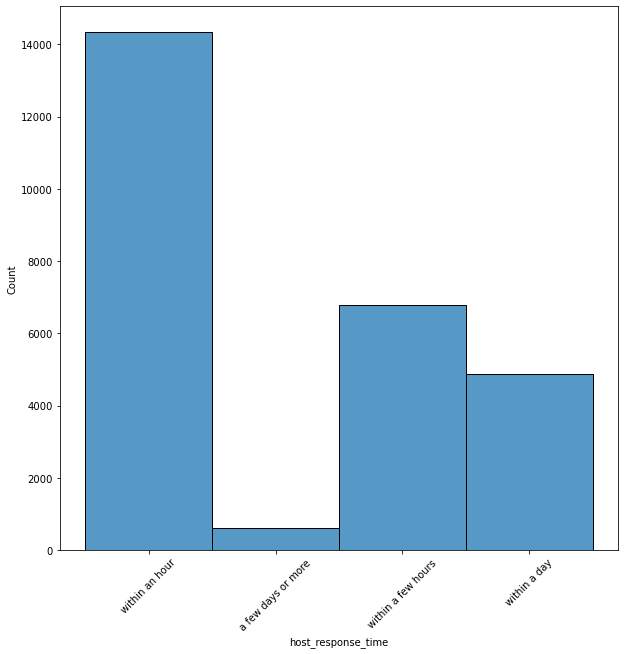

In [111]:
sns.histplot(data=airbnb_df, x='host_response_time')
plt.xticks(rotation = 45)
plt.show()

In [112]:
#Larger numbers are associated with faster response time
response_time_map = {"a few days or more": 1, "within a day": 2, "within a few hours": 3, "within an hour": 4}
airbnb_df['host_response_time'] = airbnb_df['host_response_time'].map(response_time_map)
airbnb_df.head(10)

,location,longitude,latitude,property_type,price,host_response_time,host_response_rate,cancellation_policy,review_scores_rating
0,City Island,-73.786509,40.849191,House,50,4,100%,moderate,100.0
1,City Island,-73.786609,40.849775,Apartment,125,4,100%,strict,95.0
2,City Island,-73.789328,40.850024,House,69,4,100%,moderate,97.0
3,City Island,-73.789304,40.851980,Apartment,150,4,100%,flexible,100.0
4,City Island,-73.788680,40.852054,House,101,4,100%,moderate,100.0
5,City Island,-73.789541,40.844870,House,125,4,100%,moderate,97.0
6,City Island,-73.787621,40.852582,Apartment,115,1,33%,strict,99.0
7,City Island,-73.789481,40.853061,House,62,4,100%,moderate,87.0
8,City Island,-73.784139,40.851391,House,85,4,100%,flexible,98.0
9,Allerton,-73.859378,40.866770,House,44,4,100%,strict,91.0


Next, we we assign numeric values to cancellation_policy category and let larger numbers associate with more flexible policy. 

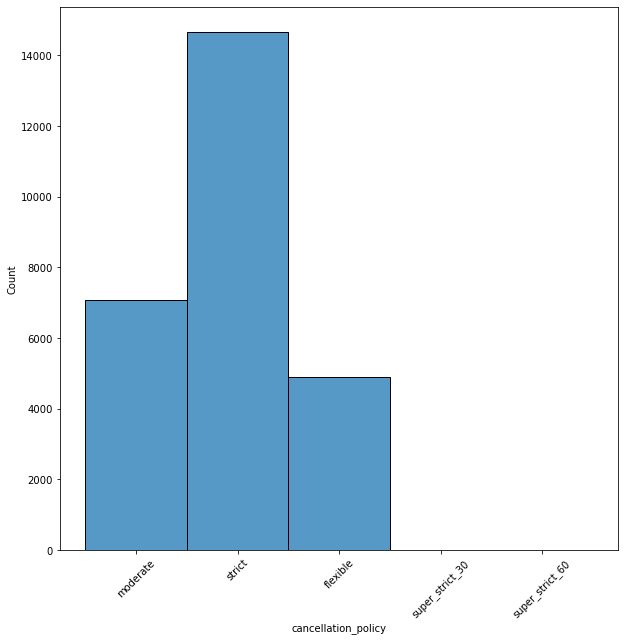

In [113]:
sns.histplot(data=airbnb_df, x='cancellation_policy')
plt.xticks(rotation = 45)
plt.show()

In [114]:
#Larger numbers are associated with more flexible policy
cancellation_map = {"super_strict_60": 1, "super_strict_30": 2, "strict": 3, "moderate": 4, "flexible": 5}
airbnb_df['cancellation_policy'] = airbnb_df['cancellation_policy'].map(cancellation_map)
airbnb_df.head()

,location,longitude,latitude,property_type,price,host_response_time,host_response_rate,cancellation_policy,review_scores_rating
0,City Island,-73.786509,40.849191,House,50,4,100%,4,100.0
1,City Island,-73.786609,40.849775,Apartment,125,4,100%,3,95.0
2,City Island,-73.789328,40.850024,House,69,4,100%,4,97.0
3,City Island,-73.789304,40.851980,Apartment,150,4,100%,5,100.0
4,City Island,-73.788680,40.852054,House,101,4,100%,4,100.0


In [115]:
print(airbnb_df['host_response_rate'].dtype)

object


We find that host_response_rate are objects, so we need to change its type to float to ease the data analysis process. 

In [118]:
airbnb_df['host_response_rate'] = airbnb_df['host_response_rate'].astype('str') 
airbnb_df['host_response_rate'] = airbnb_df['host_response_rate'].str.rstrip('%').astype('float')/100
print(airbnb_df['host_response_rate'].dtype)
airbnb_df.head()

float64


,location,longitude,latitude,property_type,price,host_response_time,host_response_rate,cancellation_policy,review_scores_rating
0,City Island,-73.786509,40.849191,House,50,4,0.01,4,100.0
1,City Island,-73.786609,40.849775,Apartment,125,4,0.01,3,95.0
2,City Island,-73.789328,40.850024,House,69,4,0.01,4,97.0
3,City Island,-73.789304,40.851980,Apartment,150,4,0.01,5,100.0
4,City Island,-73.788680,40.852054,House,101,4,0.01,4,100.0


to do: too many unique locations(211), hard to analyze, need to change to neighbourhood group

In [119]:
uniquelocation = airbnb_df['location'].unique()
print(uniquelocation)
num_unique = len(uniquelocation)
print(num_unique)

['City Island' 'Allerton' 'Ditmars Steinway' 'Soundview' 'Ozone Park'
 'Fordham' 'Whitestone' 'Arden Heights' 'Arrochar' 'Arverne' 'Astoria'
 'Bath Beach' 'Bayside' 'Battery Park City' 'Bay Ridge' 'Bay Terrace'
 'Baychester' 'Bayswater' 'Bedford-Stuyvesant' 'Belle Harbor' 'Bellerose'
 'Belmont' 'Bensonhurst' 'Bergen Beach' 'Boerum Hill' 'Borough Park'
 'Briarwood' 'Brighton Beach' 'Prospect-Lefferts Gardens' 'Mott Haven'
 'Bronxdale' 'Brooklyn Heights' 'Brownsville' 'Bushwick' 'Cambria Heights'
 'Chinatown' 'Canarsie' 'Carroll Gardens' 'Castle Hill'
 'Castleton Corners' 'Chelsea' 'Civic Center' 'Claremont Village'
 'Clason Point' 'Clifton' 'Clinton Hill' 'Co-op City' 'Cobble Hill'
 'College Point' 'Crown Heights' 'Columbia St' 'Concord' 'Concourse'
 'Concourse Village' 'Coney Island' 'Corona' 'Mount Eden' 'Mount Hope'
 'Cypress Hills' 'DUMBO' 'Dongan Hills' 'Douglaston' 'Downtown Brooklyn'
 'Dyker Heights' 'East Elmhurst' 'East Flatbush' 'East Harlem'
 'East Morrisania' 'Eltingville' '

find another dataset that has neighbourhood group & precise neighbour, use it as a dictionary

In [120]:
location_df = pd.read_csv('location.csv')
%sql location_df1 << SELECT neighbourhood, neighbourhood_group FROM location_df
location_df1.head()
location_df1.set_index("neighbourhood", inplace=True)
location_df1.head()

Returning data to local variable location_df1


,neighbourhood_group
neighbourhood,
Kensington,Brooklyn
Midtown,Manhattan
Harlem,Manhattan
Clinton Hill,Brooklyn
East Harlem,Manhattan


In [121]:
location = location_df1.to_dict('dict')
#print(location_map)
location_map = location['neighbourhood_group']

In [143]:
airbnb_df['location'].astype(str)
airbnb_df['location'] = airbnb_df['location'].map(location_map)
airbnb_df.head()

,location,longitude,latitude,property_type,price,host_response_time,host_response_rate,cancellation_policy,review_scores_rating
0,Bronx,-73.786509,40.849191,House,50,4,0.01,4,100.0
1,Bronx,-73.786609,40.849775,Apartment,125,4,0.01,3,95.0
2,Bronx,-73.789328,40.850024,House,69,4,0.01,4,97.0
3,Bronx,-73.789304,40.851980,Apartment,150,4,0.01,5,100.0
4,Bronx,-73.788680,40.852054,House,101,4,0.01,4,100.0


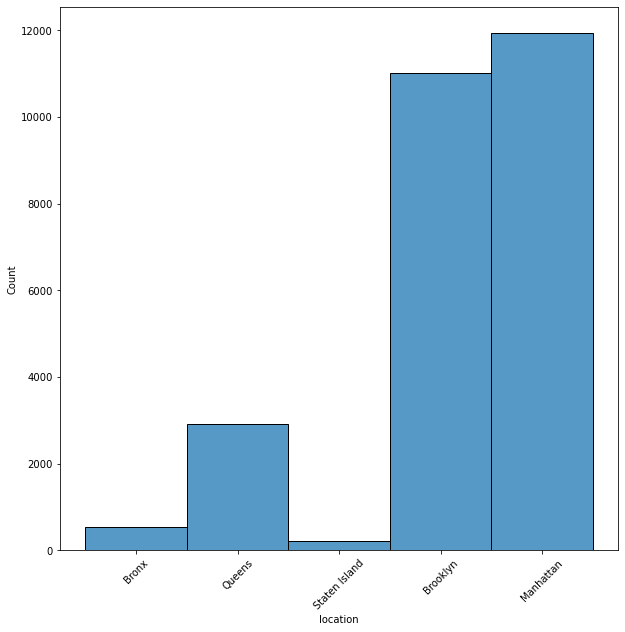

In [145]:
sns.histplot(data=airbnb_df, x='location')
plt.xticks(rotation = 45)
plt.show()

three NaN value for location, remove them

In [153]:
%sql airbnb_df << SELECT* FROM airbnb_df WHERE location is not null

Returning data to local variable airbnb_df


In [154]:
airbnb_df.isnull().sum()

location                0
longitude               0
latitude                0
property_type           0
price                   0
host_response_time      0
host_response_rate      0
cancellation_policy     0
review_scores_rating    0
dtype: int64

At this point, our data is in good quality. The clean dataframe has 26620 rows and 7 columns. The size of the dataframe is 186340, which is a large, representative dataset for our analysis. We are ready to explore the dataset further. The cleaned data is exported as cleaned_airbnb_data.csv.

In [124]:
airbnb_df.to_csv('cleaned_airbnb_data.csv')

## Data description - Aliya

The data source we used is https://www.kaggle.com/datasets/ivanovskia1/nyc-airbnb-rental-data-october-2017?resource=download. Our cleaned data contains 26620 properties and the data was accumulated in New York, NY in October 2017.

This consists of information to find out about hosts, geographical and property characteristic information used to make predictions and draw conclusions. Specifically, the observations in our data are the different Airbnb properties listed in New York City in October 2017 and the attributes are host response time, response rate, host cancellation policy, location, property type, price, and review score rating. These variables will then all be used to answer our research question regarding whether host characteristics or property characteristics impact Airbnb reviews more.  

This data was sourced from a website with Airbnb data known as Inside Airbnb. The Inside Airbnb is a mission-driven project that provides data and advocacy about Airbnb's impact on residential communities. Donations fund the collection and hosting of data, the development of analytic and activist tools, and help sustain the project. Subsequently, the data collected may have been biased towards data that shows Airbnb listings which are entire homes, showing its impact on the housing market. The Airbnb's which disrupt the hotel industry or which are property such as boats were probably less likely to be recorded.

This data was then taken from the Inside Airbnb website and got cleaned and processed into a dataset and then uploaded on kaggle. This is the dataset that was downloaded and used in this project. The people involved in the data were not aware about the study, the data about them was sourced by taking the information off the publicly available Airbnb website and compiling it. 

Link to the raw data here: https://drive.google.com/file/d/1XSb32p2DSTveb-4yvYIPQPTCIuojQ3f6/view?usp=sharing


In [125]:
variable_types = airbnb_df.dtypes
print('Here are the types of each of the variables:')
print(variable_types)

Here are the types of each of the variables:
location                 object
longitude               float64
latitude                float64
property_type            object
price                     int64
host_response_time        int64
host_response_rate      float64
cancellation_policy       int64
review_scores_rating    float64
dtype: object


The descriptions of each of the variables are: 
- location: represents the neighborhood in New York the property is located
- property_type: represents the type of Airbnb being rented for example a house, apartment or boat
- price: represents the nightly rate of the property
- host_response_time: the average time a host takes to respond
- host_response_rate: the rate a host responds to a booking request
- cancellation_policy: whether the host's policy is strict or flexible (should we change this to boolean?)
- review_scores_rating: the Airbnb rating on a scale of 0-100

## Data Analysis- Douglas

### Summary Statistics

The first step in exploratory data analysis was to calculate summary functions for some of the relevant variables. This includes the standard deviation and mean for numerical values for the property characteristics mainly price and host characteristics mainly response time compared to the review scores.

We will then analyze how review scores also vary to get a general idea of the average review and the standard deviation.

In [126]:
from statistics import mean, median, mode, stdev

price_mean = airbnb_df['price'].mean()
print('Mean of price: ' + str(price_mean))
price_std = airbnb_df['price'].std()
print('Standard deviation of price: ' + str(price_std))

response_rate_mean = airbnb_df['host_response_rate'].mean()
print('Mean of response: ' + str(response_rate_mean))
response_rate_mean_std = airbnb_df['host_response_rate'].std()
print('Standard deviation of response rate: ' + str(response_rate_mean_std))

review_scores_mean = airbnb_df['review_scores_rating'].mean()
print('Mean of reviews: ' + str(review_scores_mean))
review_scores_std = airbnb_df['review_scores_rating'].std()
print('Standard deviation of reviews: ' + str(review_scores_std ))

Mean of price: 143.84830954169797
Standard deviation of price: 173.79921548824515
Mean of response: 0.00946408339594002
Standard deviation of response rate: 0.001472526239574245
Mean of reviews: 93.65638617580767
Standard deviation of reviews: 7.469818466605432



As for the property characteristics we calculated the average nightly rate for an Airbnb rental was \\$143.85, and that the standard deviation was significantly high at \\$173.80. This indicated that there is drastic variation in the nightly rates of Airbnb rentals. This was to be expected as the minimum nightly rate in our dataset was \\$0 , and the max was \\$10,000. Excluding such outliers the most common low nightly rates were around \\$ 40 a night and the most common high nightly rates were around \$400 a night. Despite the outliers this would still be a high standard deviation and therefore there still a relatively large spread in nightly rates.

As for the host characteristics the mean was 95% and the standard deviation was significantly low at 0.14. If a host reponds to all guest messages at some point their response rate is 100%, and if they never respond to guests their response rate is 0%. The mean and standard deviataion indicate that almost all hosts responded to guests messages at some point, and having a host not respond to a few guests was extremely rare. 

As for the review scores, the mean was 93.66 and the standard deviation was 7.47. The mean scores are very high as guests tended to enjoy the rentals they stayed at. The standard deviation is very high as well, indicating that there was large fluctuation in property ratings. Despite this variation, it was very rare for ratings to fall below 80%. 

At this stage, while this information is useful, we are interested in finding more data which can further provide better analysis and answer our research question of whether the property or the host is more impactful on property reviews.


### Visual displays

### Property Characteristics

The next step in our exploratory data was to create a histogram to further analyze the data visually. For the first histogram we decided to compare the review scores vs. price. This will determine whether a relationship exists between review scores and price.

Before doing so, we need to inspect whether there is any outlier in price by drawing a boxplot. We need to think about how to deal with outliers with extremely high price that might create a bias for our model. 


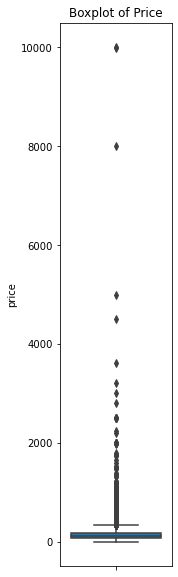

In [127]:
plt.figure(figsize=(2,10))
sns.boxplot(y ='price', data=airbnb_df)
plt.title('Boxplot of Price')
plt.show()

From the boxplot, we can see that the 25 percentile, 50 percentile, and 75 percentile are all far below 2000. There are some outliers at approximately \\$10000, \\$8000, and \\$2000-\\$5000 range. These extremely large numbers do not look representative of our population, and it is possible that the property owners list these price intentionally to prevent booking. Thus, it is worth considering excluding these numbers. If we exclude these numbers, the mean and standard deviation of price will both decrease. 

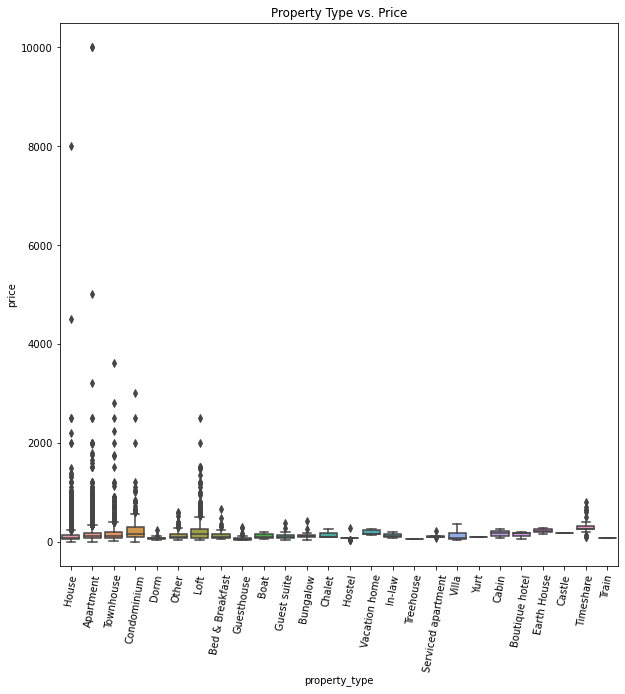

In [128]:
airbnb_df['property_type'].groupby(by=airbnb_df['property_type']).describe()
sns.boxplot(x='property_type', y='price', data=airbnb_df)
plt.title('Property Type vs. Price')
plt.xticks(rotation = 80)
plt.show()

From this boxplot, we can see that there is there is a strong relationship between rental rate and the type of house. The relationship between the two variables indicates that certain property types have higher prices associated with them. Houses for example are priced much higher than smaller units such as dorms and hostels. What we found interesting in this visual graph is that apartments are priced similarly to houses, of which both are priced high.

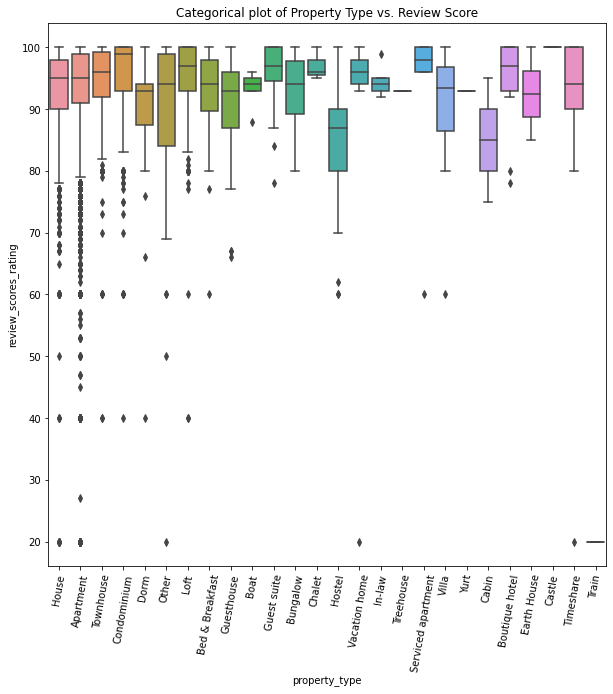

In [129]:
sns.boxplot(x='property_type', y='review_scores_rating', data=airbnb_df)
plt.title('Categorical plot of Property Type vs. Review Score')
plt.xticks(rotation = 80)
plt.show()


From this boxplot, we can see that there is a relationship between property type and review score. For some property types, such as hostel, dorm, and cabin, the owners tend to receive a lower review rating, whereas apartment, loft, townhouse and etc. tend to have higher review rating. This indicates that there is a strong relationship between not only the type of property and price, but also the type of property and review score.


### Model- Doug (add one model here)

Finally we decided to create a linear regression model in order to calculate and compare the strength in the relationship between the property characteristics and reviews, as well as the host characteristics and reviews. The variable we used for the property characteristics was the price, and the variable we used for the host characteristics was the response rate. 

The linear regression models demonstrated a broad relationship between property characteristics and reviews, and host characteristics and reviews. 

While calculating the summary statistics, visual displays and regression models brought us closer to answering our research question on whether property characteristics or host characteristics are more impactful on review scores, more in depth analysis would be beneficial in solidifying a conclusion. 


## Pre-Registration Statement

### Analysis 1: Investigate whether property characteristics, specifically location, longitude, latitude, and price, have an effect on the review score of an airbnb listing. 

In this analysis, we want to determine property characteristics’ impact on the review score of an airbnb listing. We will use four property characteristics from our dataset that we believe can have a potential relationship with the review score: location, latitude, longitude, and price. We will first run a single-input regression analysis for each of variable. If we find collinearity among these variables, we will then run a multivariate analysis to see if there is any relationship between these variables and the review score of airbnb properties. 

### Analysis 2: Investigate the relationship between an airbnb’s host characteristics (e.g. response time) and review score.

Airbnb’s host characteristics potentially affect the review score. In our dataset, there are three variables defining host characteristics: host_response_time, host_response_rate, and cancellation_policy.

First, we will investigate the relationship between host_response_time and review score to test if a faster host response would result in a higher review score.We will conduct a seaborn regplot to visualize a scatterplot and regression line for host_response_time against review score.

Next, we will investigat ethe relationship betweena host_response_rate and review score to test if the frequency of the hosts’ responses would affect the Airbnb’s review score. We predefined the four levels of host_reponses_rate as following: “a few days or more”=1, “within a day”=2, “within a few hours”=3, “within an hour”=4. We will conduct another seaborn regplot  to visualize a regression analysis between host_response_rate and review score.

Thirdly, we will investigate the relationship between cancellation_policy and review score to test if the strictness in cancellation policies would affect the Airbnb’s review score. We defined the levels of cancellation policies by five numerical groups: “super_strict_60”=1，”super_strict”=2, “strict”=3, “moderate”=4, “flexiable”=5. We will perform a linear regression analysis between cancellation_policy and review score.

Lastly, we will interpret the r square values for the three combinations to analyze which independent variable captures more variation in review scores.


## Evaluation Of Significance (Aliya and Linda)

 Analysis 1: Our first analysis examines the relationship between property characteristics and review score of airbnb properties. We previously defined property characteristics as property type, longitude and latitude (location) and price of the airbnb. 

In [130]:

from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error 
def run_regression(x,train,test,y):
    reg = LinearRegression().fit(train[x],train[y])
    train_predict=reg.predict(train[x])
    test_predict=reg.predict(test[x])
    mse1 = mean_squared_error(train_predict,train[y])
    mse2 = mean_squared_error(test_predict,test[y])
    mae1 = mean_absolute_error(train_predict,train[y])
    mae2 = mean_absolute_error(test_predict,test[y])
    ## add what each variable means in the print
    print(x)        
    print(reg.coef_)
    print(reg.intercept_)
    print(np.sqrt(mse1))
    print(np.sqrt(mse2))
    print(mae1)
    print(mae2)

In [131]:
clean_df = pd.read_csv('cleaned_airbnb_data.csv')
print(clean_df.head())


   Unnamed: 0     location  longitude   latitude property_type  price  \
0           0  City Island -73.786509  40.849191         House     50   
1           1  City Island -73.786609  40.849775     Apartment    125   
2           2  City Island -73.789328  40.850024         House     69   
3           3  City Island -73.789304  40.851980     Apartment    150   
4           4  City Island -73.788680  40.852054         House    101   

   host_response_time  host_response_rate  cancellation_policy  \
0                   4                0.01                    4   
1                   4                0.01                    3   
2                   4                0.01                    4   
3                   4                0.01                    5   
4                   4                0.01                    4   

   review_scores_rating  
0                 100.0  
1                  95.0  
2                  97.0  
3                 100.0  
4                 100.0  


###Explanation of Cells below: 

We are first going assign property types to a categorical variable so we can analyze how each property type impacts the review score of the airbnb.

In [132]:
property_map = {"House": 1, "Apartment": 2, "Loft": 3, "Condominium": 4, "Townhouse": 5,"Guesthouse": 6,"Other": 7,"Bed & Breakfast": 8}
clean_df['property_type'] = clean_df['property_type'].map(property_map)

Then we are splitting the data into both test and train data so we can run regressions on the individual property characteristic variables on the review score to see how a change in the property characteristic impacts the review score.

In [133]:
airbnb_train, airbnb_test = train_test_split(clean_df, test_size=0.1,random_state=2950)

In [134]:
for x in np.array(['latitude','longitude','price']):
    run_regression([x],airbnb_test,airbnb_train,'review_scores_rating')

['latitude']
[-0.93651683]
132.10605752564692
6.822597150185912
7.543711737463575
4.805658718078539
5.048733439435395
['longitude']
[-3.40709984]
-157.99985377218496
6.821019619437627
7.5416984687071915
4.807362705038345
5.049385416189216
['price']
[0.00394057]
93.40889502955602
6.805325077877057
7.56456427843175
4.798112393610785
5.054859450797348


So far we see that the latitude has a positive relationship with the review score of the airbnb. This means that if we increase in latitude (go further north) the review scores of the airbnb are higher. 

However, for longitude, there is a negative relationship between longitude and price. When we increase in longitude, there is decrease in 157.99 units of the review score. 

Lastly, for price, increasing the price of an airbnb tends to have a positive impact on the review score of the airbnb. 

In [135]:
run_regression(['latitude','longitude','price'],airbnb_train,airbnb_test,'review_scores_rating')

['latitude', 'longitude', 'price']
[-3.76850568e+00 -4.63764280e+00  6.64574103e-04]
-95.94967862108089
7.529853003933807
6.827083015701544
5.110679228119048
4.885217255095823


Having a multivariate regression with all of the property characteristics, we are able to see that latitude and longitude have a very small joined impact on the review score of the airbnb. However, the price has a small negative impact on the review score of an airbnb.

### Analysis 2: the relationship between host characteristics and review score

Our second analysis examines the relationship between host characteristics and review score of airbnb properties. We previously defined host characteristics as host response time, host response rate and cancellation policy. 

**Explanation for cell below:** First, we are interested in the impact of individual host characteristic on the review score. We run a linear regression and generate a regression plot for host response time variable. The regression line in the plot is almost horizontaly, which shows there is an extremely low correlation between host response time and review scores.

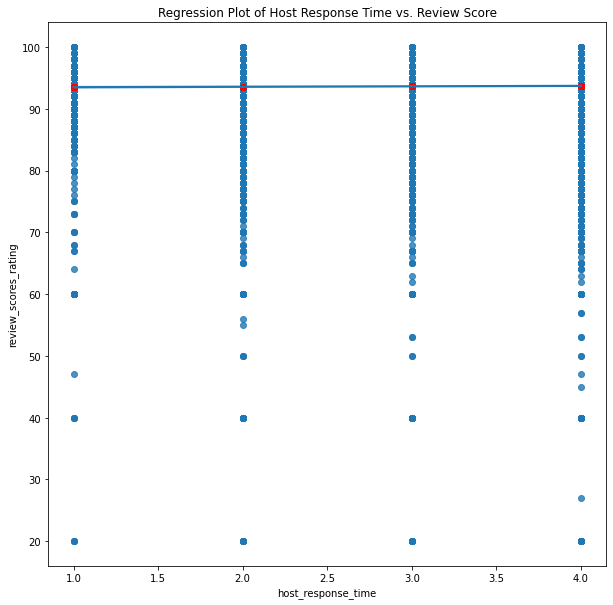

In [136]:
response_time_model = LinearRegression().fit(airbnb_df[['host_response_time']], airbnb_df['review_scores_rating'])
sns.regplot(x=airbnb_df["host_response_time"], y=airbnb_df["review_scores_rating"])
plt.scatter(airbnb_df['host_response_time'], response_time_model.predict(airbnb_df[["host_response_time"]]), c='red')
plt.title('Regression Plot of Host Response Time vs. Review Score')
plt.show()

**Explanation for cell below:** The model shows a slightly positive relationship between host response time and the review score of an airbnb listing. Specifically, we expect that each one unit increase in host response time corresponds to a 0.071 increase in the review score. This model indicates that when the host response time is 1, which represents "a few days or more," we expect the review score of the property to be 93.491 (coefficient+intercept). We see many outliers that give low review score ratings. The sign of the slope matches our expectation, because we expect faster response rate would lead to higher review score. The $r^2$ of the linear regression model for response time against review score is 0.000, which can be interpreted as 0% of the variation in the output variable can be explained  by the input variable host response time. 

In [137]:
response_time_score = response_time_model.score(airbnb_df[['host_response_time']], airbnb_df['review_scores_rating'])
print('host response time coefficient: {:.3f}'.format(float(response_time_model.coef_)))
print('host response time intercept: {:.3f}'.format(response_time_model.intercept_))
print('r^2 score of the response time model: {:.3f}'.format(response_time_score))

host response time coefficient: 0.071
host response time intercept: 93.420
r^2 score of the response time model: 0.000


**Explanation for cell below:** We then run a linear regression and generate a regression plot for host response rate variable. The regression line in the plot is upward sloping, which indicates there is positive relationship between host response rate and review scores.

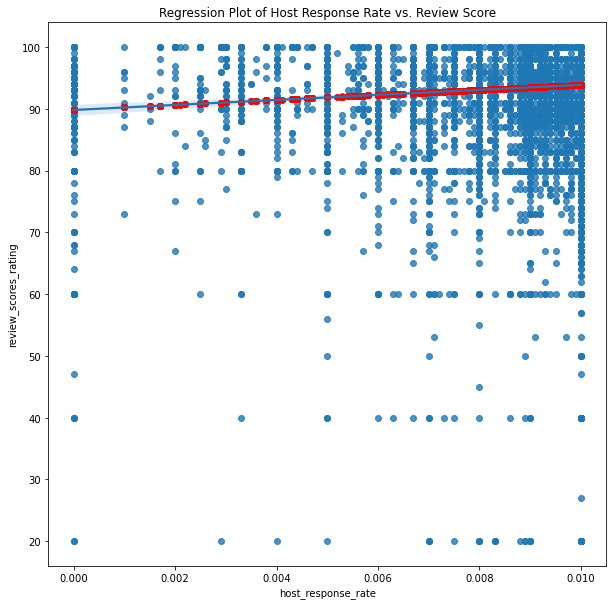

In [138]:
response_rate_model = LinearRegression().fit(airbnb_df[['host_response_rate']], airbnb_df['review_scores_rating'])
sns.regplot(x=airbnb_df["host_response_rate"], y=airbnb_df["review_scores_rating"])
plt.scatter(airbnb_df['host_response_rate'], response_rate_model.predict(airbnb_df[["host_response_rate"]]), c='red')
plt.title('Regression Plot of Host Response Rate vs. Review Score')
plt.show()

**Explanation for cell below:** The model shows a positive relationship between host response rate and the review score of an airbnb listing. Specifically, we expect that each one unit increase in host response rate corresponds to a 4.071 increase in the review score. This model indicates that when the host response rate is 0, we expect the review score of the property to be 89.803. The sign of the slope matches our expectation, because we expect higher response rate would lead to higher review score. The $r^2$ of the linear regression model for response rate against review score is 0.006, which can be interpreted as 0.6% of the variation in the output variable can be explained by the input variable host response rate.

In [139]:
response_rate_score = response_rate_model.score(airbnb_df[['host_response_rate']], airbnb_df['review_scores_rating'])
print('host response rate coefficient: {:.3f}'.format(float(response_rate_model.coef_)))
print('host response rate intercept: {:.3f}'.format(response_rate_model.intercept_))
print('r^2 score of the response rate model: {:.3f}'.format(response_rate_score))

host response rate coefficient: 407.138
host response rate intercept: 89.803
r^2 score of the response rate model: 0.006


**Explanation for cell below:** Next, we run a linear regression and generate a regression plot for cancellation policy variable. The regression line in the plot is upward sloping, which indicates there is positive relationship between host response rate and review scores.

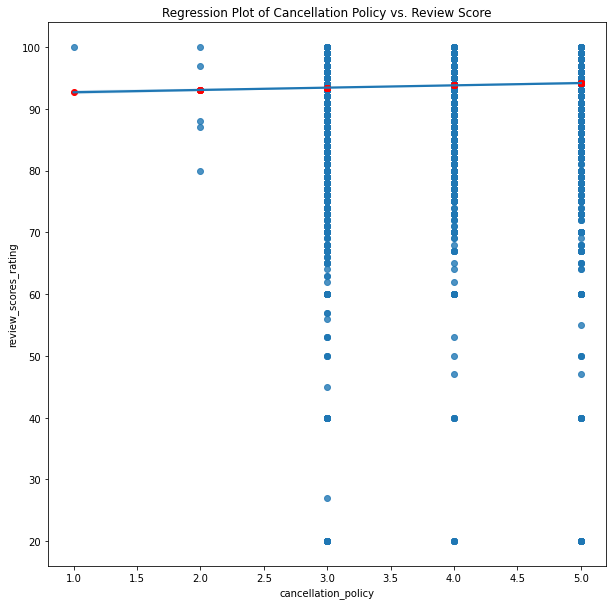

In [140]:
policy_model = LinearRegression().fit(airbnb_df[['cancellation_policy']], airbnb_df['review_scores_rating'])
sns.regplot(x=airbnb_df["cancellation_policy"], y=airbnb_df["review_scores_rating"])
plt.scatter(airbnb_df['cancellation_policy'], policy_model.predict(airbnb_df[["cancellation_policy"]]), c='red')
plt.title('Regression Plot of Cancellation Policy vs. Review Score')
plt.show()

**Explanation for cell below:** The model shows a positive relationship between cancellation policy and the review score of an airbnb listing. Specifically, we expect that each one unit increase in cancellation policy corresponds to a 0.373 increase in the review score. This model indicates that when the cancellation policy is 1, which represents "super strict 60", we expect the review score of the property to be 92.675 (intercept+coefficient). The sign of the slope matches our expectation, because we expect more flexible cancellation policy would lead to higher review score. The $r^2$ of the linear regression model for response time against review score is 0.001, which can be interpreted as 0.1% of the variation in the output variable can be explained by the variation in the cancellation policy.

In [141]:
policy_score = policy_model.score(airbnb_df[['cancellation_policy']], airbnb_df['review_scores_rating'])
print('cancellation policy coefficient: {:.3f}'.format(float(policy_model.coef_)))
print('cancellation policy intercept: {:.3f}'.format(policy_model.intercept_))
print('r^2 score of the cancellation policy model: {:.3f}'.format(policy_score))

cancellation policy coefficient: 0.373
cancellation policy intercept: 92.302
r^2 score of the cancellation policy model: 0.001


## Data limitations - Aliya

One of the major limitations of this study is that there are a lot of fake ratings. For example, hosts will sometimes rate their own property or ask others to do it to increase the percentage of their review score. This will lead to bias in the model since some of the Airbnb's results are not an accurate representation of what people think about the listing. This leads to some bias in our data of the success of some properties being exaggerated. 

Secondly, a large number of properties had very few reviews or none at all. We removed the properties without a review score from our data when we cleaned it but this means we did not account for several of the listings available in NYC and we still have the properties with few ratings. Also, it is proven that people are more likely to leave a review if it's a negative experience.This means that the results are likely skewed where properties with lower ratings are more likely to have been in our sample since we removed the properties with no ratings.

Additionally, to draw our conclusions, we have to make assumptions about what characteristics make a good host and narrow down which ones really differentiate a property. We chose response rate, cancellation policy, and response time to be the ones that determine a good host but there may be missing characteristics that impact the success of a host. Similarly, we narrowed it down to location, property type, and price for the property attributes; however, many other things could be impacting the Airbnb listing which are not accounted for.

## Source Code- Aliya

## Acknowledgements- Doug

In order to gain a better understanding of our research, we found it helpful to analyze the broader picture first. We found exploring non-data related resources involving our hypothesis exceptionally helpful. For example, we first familiarized ourself with the website design of Airbnb. We carefully analyzed numerous property listings on Airbnb’s website before delving into the data set. This was done to grasp an understanding for the positioning of both property characteristics and host characteristics and understand the big picture of our research. 

During the data analysis process, when we encountered roadblocks we found asking questions through our class’s Ed Discussion to be the most helpful. Secondly we found asking questions on Stack Overflow, given its popularity and simplicity, to be useful as well. If we had difficulty regarding concepts, we turned to YouTube videos posted from reputable channels to be helpful. This is because it provided a visual representation of the question at hand, which was highly beneficial. 


## Appendix - Linda

## Questions for reviewers